In [1]:
import os
import zlib
import math
import io
from matplotlib import pyplot as plt
import sys
import kitti_util as utils
import numpy as np
import cv2

## Helper functions

In [2]:
def get_box_transformation_matrix(obj_loc, obj_size, ry):
    """Create a transformation matrix for a given label box pose."""

    tx,ty,tz = obj_loc
    c = math.cos(ry)
    s = math.sin(ry)

    sl, sh, sw = obj_size

    return np.array([
        [ sl*c,-sw*s,  0,tx],
        [ sl*s, sw*c,  0,ty],
        [    0,    0, sh,tz],
        [    0,    0,  0, 1]])

def get_box_transformation_matrix_my(obj_loc, obj_size, ry):
    """Create a transformation matrix for a given label box pose."""

    tx,ty,tz = obj_loc
    c = math.cos(ry)
    s = math.sin(ry)

    sl, sh, sw = obj_size

    return np.array([
        [       -sl*c,    0,  sw*s,    tx],
        [          0,  -sh,    0,      ty],
        [    -sl*(-s),    0,  sw*c,    tz],
        [          0,    0,    0,     1]])

def cart2hom(pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

def get_lidar_in_image_fov(pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=0.5):
    """ Filter lidar points, keep those in image FOV """
    
    pts_3d_velo = cart2hom(pc_velo)  # nx4
    pts_3d_ref = np.dot(pts_3d_velo, np.transpose(calib.V2C))
    
    pts_3d_ref = pts_3d_ref[pts_3d_ref[:,2]>0,:]
    pts_3d_rect = np.transpose(np.dot(calib.R0, np.transpose(pts_3d_ref)))
    pts_3d_rect = cart2hom(pts_3d_rect)
    pts_2d = np.dot(pts_3d_rect, np.transpose(calib.P))  # nx3
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    pts_2d = pts_2d[:, 0:2]
    
    distances = np.sqrt(np.sum(pts_3d_ref**2, axis=1))
    
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )

    if return_more:
        return pts_2d, fov_inds, distances
    else:
        return imgfov_pc_velo
 
def show_lidar_on_image_my(pc_velo, img, calib, img_width, img_height):
    """ Project LiDAR points to image """
    pts_2d, fov_inds, distances = get_lidar_in_image_fov(
        pc_velo, calib, 0, 0, img_width, img_height, True
    )
    imgfov_pts_2d = pts_2d

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    max_depth = max(distances)
    colors = np.round((distances/max_depth)*255).astype(int)
    
    for i in range(imgfov_pts_2d.shape[0]):
        cv2.circle(
            img,
            (int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),
            2,
            color=cmap[colors[i],:],
            thickness=-1,
        )

    return img

def show_interactive_lidar(lidar_scan, cam_idx=2, calib=None, objects=[], with_boxes=False, to_save=True, to_show=False):
    import plotly.graph_objects as go
    Tr_V2C = np.eye(4)
    Tr_V2C[:3,:] = calib.V2C
    lidar_scan = np.matmul(Tr_V2C, lidar_scan.T).T
    
    distances = np.sqrt(np.sum(lidar_scan**2, axis=1))
    scatter = go.Scatter3d(x=lidar_scan[:,2], y=-lidar_scan[:,0], z=-lidar_scan[:,1],
                                   mode='markers',marker=dict(size=2,                # set color to an array/list of desired values
                                                              color=distances,
                                                              colorscale='Viridis',   # choose a colorscale
                                                              opacity=0.8
                                                            ))
    if with_boxes:
        x_lines = []
        y_lines = []
        z_lines = []

        def f_lines_add_nones():
            x_lines.append(None)
            y_lines.append(None)
            z_lines.append(None)

        ixs_box_0 = [0, 1, 2, 3, 0]
        ixs_box_1 = [4, 5, 6, 7, 4]
        axes_transformation = np.array([[0,-1,0,0],
                                        [0,0,-1,0],
                                        [1,0,0,0],
                                        [0,0,0,1]])
        axes_transformation_inv = np.linalg.inv(axes_transformation)
        for obj in objects:
#             points = view_points(box.corners(), view=np.eye(3), normalize=False)
            Tr_2box = get_box_transformation_matrix_my(obj.t, (obj.l, obj.h, obj.w), obj.ry)
#             Tr_2box = np.matmul(Tr_2box,axes_transformation)

            x_corners =  np.array([1/2, -1/2, -1/2, 1/2, 1/2, -1/2, -1/2, 1/2])
            y_corners =  np.array([1, 1, 0, 0, 1, 1, 0, 0])
            z_corners =  np.array([1/2, 1/2, 1/2, 1/2, -1/2, -1/2, -1/2, -1/2])            
            
            corners = np.vstack((x_corners, y_corners, z_corners, np.ones(8)))
            points = np.matmul(Tr_2box, corners)
            
            x_lines.extend(points[0, ixs_box_0])
            y_lines.extend(points[1, ixs_box_0])
            z_lines.extend(points[2, ixs_box_0])
            f_lines_add_nones()
            x_lines.extend(points[0, ixs_box_1])
            y_lines.extend(points[1, ixs_box_1])
            z_lines.extend(points[2, ixs_box_1])
            f_lines_add_nones()
            for i in range(4):
                x_lines.extend(points[0, [ixs_box_0[i], ixs_box_1[i]]])
                y_lines.extend(points[1, [ixs_box_0[i], ixs_box_1[i]]])
                z_lines.extend(points[2, [ixs_box_0[i], ixs_box_1[i]]])
                f_lines_add_nones()
        y_lines = [-1*val if val is not None else val for val in y_lines]
        x_lines = [-1*val if val is not None else val for val in x_lines]
        lines = go.Scatter3d(x=z_lines, y=x_lines, z=y_lines, mode="lines", name="lines")
        fig = go.Figure(data=[scatter, lines])
    else:
        fig = go.Figure(data=[scatter])
    fig.update_layout(scene_aspectmode="data")
    if to_save:
        cam_idx = cam_idx if cam_idx is not None else 2
        fig.write_html("scene_file{}.html".format(cam_idx))
    if to_show:
        fig.show()
        
def bounding_box_filter(points, x_range, y_range, z_range):
    """ Compute a bounding_box filter on the given points

    Parameters
    ----------                        
    points: (n,3) array
        The array containing all the points's coordinates. Expected format:
            array([
                [x1,y1,z1],
                ...,
                [xn,yn,zn]])

    min_i, max_i: float
        The bounding box limits for each coordinate. If some limits are missing,
        the default values are -infinite for the min_i and infinite for the max_i.

    Returns
    -------
    bb_filter : boolean array
        The boolean mask indicating wherever a point should be keeped or not.
        The size of the boolean mask will be the same as the number of given points.

    """
    min_x, max_x = x_range
    min_y, max_y = y_range
    min_z, max_z = z_range

    bound_x = np.logical_and(points[:, 0] > min_x, points[:, 0] < max_x)
    bound_y = np.logical_and(points[:, 1] > min_y, points[:, 1] < max_y)
    bound_z = np.logical_and(points[:, 2] > min_z, points[:, 2] < max_z)

    bb_filter = np.logical_and(np.logical_and(bound_x, bound_y), bound_z)

    return points[bb_filter]

def filter_boxes(objects, lidar_scan, calib, thresh=5):
    lidar_scan_new = np.copy(lidar_scan)
    lidar_scan_new[:,3] = 1
    
    Tr_V2C = np.eye(4)
    Tr_V2C[:3,:] = calib.V2C
    
    lidar_scan_new = np.matmul(Tr_V2C, lidar_scan_new.T)
    lidar_scan_new=lidar_scan_new.T
    
    print('Num objects before filtering {}'.format(len(objects)))
    filtered_objects = []
    for obj in objects:
        Tr_2box = get_box_transformation_matrix_my(obj.t, (obj.l, obj.h, obj.w), obj.ry)
        Tr_2box_inv = np.linalg.inv(Tr_2box)
        lidar_scan_box = np.matmul(Tr_2box_inv, lidar_scan_new.T)
        lidar_scan_box = lidar_scan_box.T
#         print(lidar_scan_box)
        x_range = [-1/2, 1/2]
        y_range = [0, 1]
        z_range = [-1/2, 1/2]
        filtered_points = bounding_box_filter(lidar_scan_box[:,:3], x_range, y_range, z_range)
        
        if len(filtered_points)>=thresh:
            filtered_objects.append(obj)
    print('Num objects after filtering {}'.format(len(filtered_objects)))       
    return filtered_objects
    
def show_image_with_boxes_my(img, objects, calib, thresh=0, show2d=False, depth=None):
    """ Show image with 2D bounding boxes """
    img1 = np.copy(img)  # for 2d bbox
    img2 = np.copy(img)  # for 3d bbox
    img3 = np.copy(img)  # for 3d bbox
    
    for obj in objects:
        if obj.type == "DontCare":
            continue
        cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (0, 255, 0),
            2,
        )
        

        box3d_pts_2d, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        if box3d_pts_2d is None or box3d_pts_3d is None:
            print('Skip box')
            continue
        img2 = utils.draw_projected_box3d(img2, box3d_pts_2d)

    fig=plt.figure(figsize=(32, 16))
    
    fig.add_subplot(2, 1, 1)
    plt.imshow(img2)
    
    if show2d:
        fig.add_subplot(2, 1, 2)
        plt.imshow(img1)
        
    if depth is not None:
        plt.imshow(depth)
    plt.show()

def show_3d_detections(sample_name, gt_root_folder, det_folder=None, cam_idx=2, thresh=0, kitti_style=True, show_lidar_interactive=False, show_lidar_img=True, show2d=False, lidar_dtype=float):
    gt_label_folder = os.path.join(gt_root_folder,'label_{}/'.format(cam_idx))

    gt_image_folder = os.path.join(gt_root_folder,'image_{}/'.format(cam_idx))
    gt_lidar_folder = os.path.join(gt_root_folder,'velodyne/')
    gt_calib_folder = os.path.join(gt_root_folder,'calib/')

    img_filename = os.path.join(gt_image_folder, sample_name+'.png')
    calib_filename = os.path.join(gt_calib_folder, sample_name+'.txt')
    gt_filename = os.path.join(gt_label_folder, sample_name+'.txt')
    lidar_filename = os.path.join(gt_lidar_folder, sample_name+'.bin')
    
    img = utils.load_image(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lidar_scan = utils.load_velo_scan(lidar_filename, dtype=lidar_dtype)
    
    if kitti_style:
        cam_idx=None
    calib = utils.Calibration(calib_filename, cam_idx=cam_idx)
    objects_gt = utils.read_label(gt_filename)
    
    if show_lidar_interactive:
        show_interactive_lidar(lidar_scan, cam_idx=cam_idx, calib=calib, objects=objects_gt, with_boxes=True)
    
    if thresh>0:
        filtered_objects = filter_boxes(objects_gt, lidar_scan, calib, thresh=thresh)
    else:
        filtered_objects = objects_gt
    if show_lidar_img:
        h, w, c = img.shape
        img = show_lidar_on_image(lidar_scan[:,:3], img, calib, w, h)
    if det_folder is not None:
        det_filename = os.path.join(det_folder, sample_name+'.txt')
        objects = utils.read_label(det_filename)
        print(objects)
        show_image_with_boxes_my(img, objects, calib, show2d=show2d, depth=None)
    else:
        show_image_with_boxes_my(img, filtered_objects, calib, show2d=show2d,  depth=None)  

## WAYMO 

### Plot sample from one camera

In [31]:
cam_idx = 0
sample_name = '000000000000043'
thresh=5
show_lidar_img = True
show_lidar_interactive = False
gt_root_folder = '/dataset/kitti_format/waymo/training/'

Num objects before filtering 32
Num objects after filtering 12


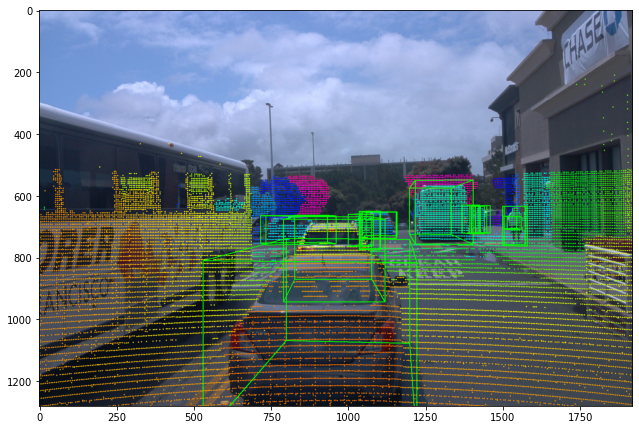

In [32]:
show_3d_detections(sample_name, 
                   gt_root_folder, 
                   cam_idx=cam_idx, 
                   thresh=thresh,
                   show_lidar_img=show_lidar_img,
                   show_lidar_interactive=show_lidar_interactive, 
                   kitti_style=False)

### Plot sample from all cameras

In [25]:
sample_name = '000000000000043'
thresh=5
show_lidar_img = False
show_lidar_interactive = False
gt_root_folder = '/dataset/kitti_format/waymo/training/'

Num objects before filtering 32
Num objects after filtering 12


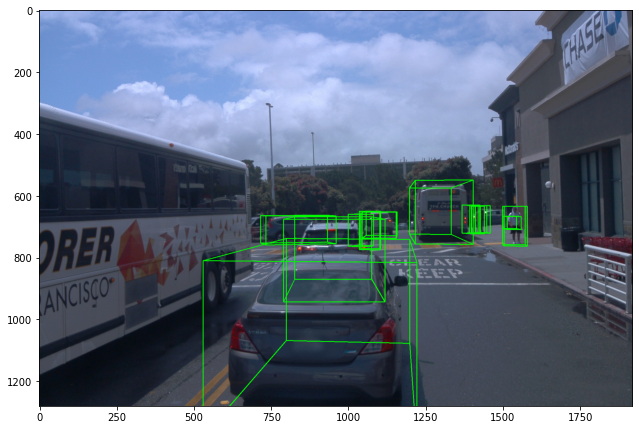

Num objects before filtering 39
Num objects after filtering 9


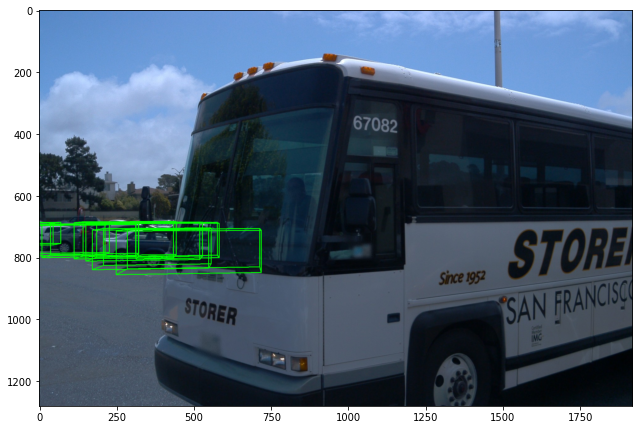

Num objects before filtering 7
Num objects after filtering 7


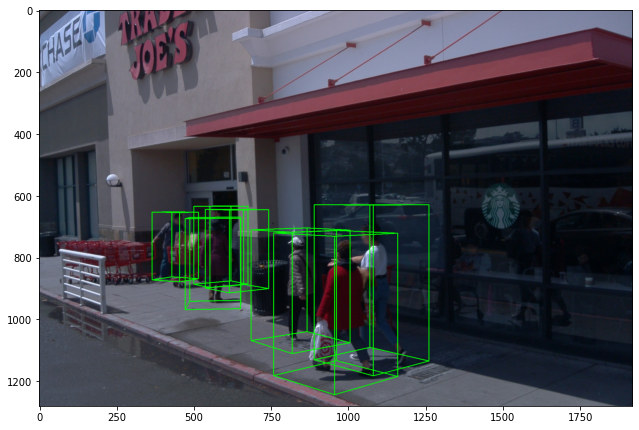

Num objects before filtering 28
Num objects after filtering 18


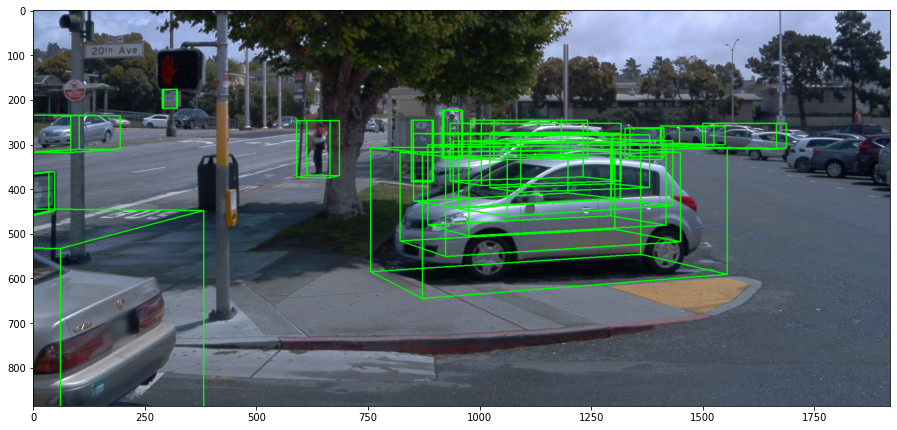

No such file for camera 4


In [26]:
for cam_idx in range(5):
    try:
        show_3d_detections(sample_name, 
                       gt_root_folder, 
                       cam_idx=cam_idx, 
                       thresh=thresh,
                       show_lidar_img=show_lidar_img,
                       show_lidar_interactive=show_lidar_interactive, 
                       kitti_style=False)
    except FileNotFoundError:
        print('No such file for camera {}'.format(cam_idx))

## TEST DETECTION

In [10]:
sample_name = '015031'
show_lidar_img = True
show_lidar_interactive = False
thresh =0
det_folder = '/root/workdir/frustum-convnet/output/car_train/val_nms/result/data/'
gt_root_folder = '/dataset/kitti_format/argo/val/'

[]
0


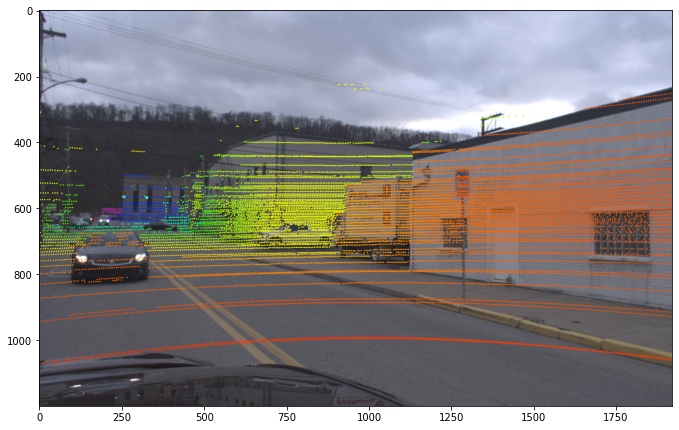

In [11]:
show_3d_detections(sample_name, 
                   gt_root_folder,
                   det_folder=det_folder,
                   thresh=thresh,
                   show_lidar_img=show_lidar_img,
                   show_lidar_interactive=show_lidar_interactive, 
                   kitti_style=True,
                   lidar_dtype=np.float32)

## TEST ARGO GT VAL

In [15]:
sample_name = '015031'
show_lidar_img = True
show_lidar_interactive = False
thresh =0
gt_root_folder = '/dataset/kitti_format/argo/val/'

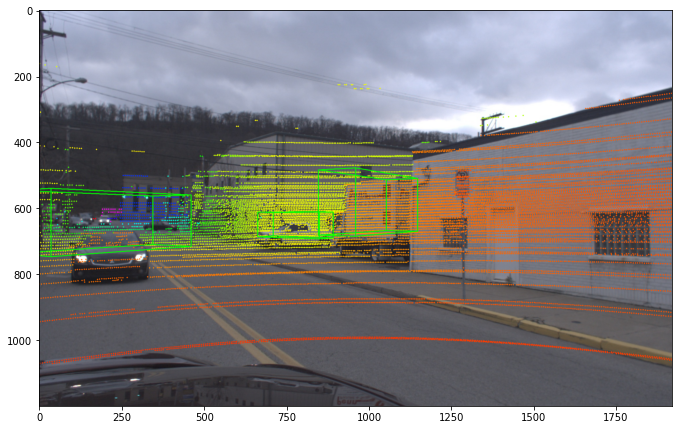

In [16]:
show_3d_detections(sample_name, 
                   gt_root_folder,
                   thresh=thresh,
                   show_lidar_img=show_lidar_img,
                   show_lidar_interactive=show_lidar_interactive, 
                   kitti_style=True,
                   lidar_dtype=np.float32)

## TEST ARGO TRAIN

In [17]:
sample_name = '091843'
show_lidar_img = True
show_lidar_interactive = False
thresh =0
gt_root_folder = '/dataset/kitti_format/argo/train/'

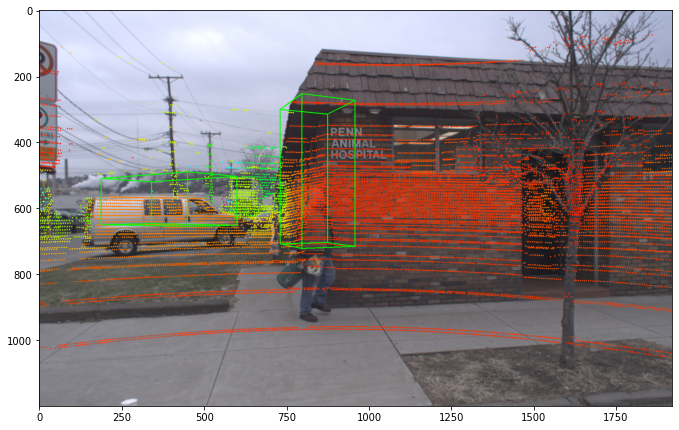

In [18]:
show_3d_detections(sample_name, 
                   gt_root_folder,
                   thresh=thresh,
                   show_lidar_img=show_lidar_img,
                   show_lidar_interactive=show_lidar_interactive, 
                   kitti_style=True,
                   lidar_dtype=np.float32)

## TEST KITTI TRAIN

In [21]:
sample_name = '003197'
show_lidar_img = False
show_lidar_interactive = False
thresh =0
gt_root_folder = '/dataset/kitti_format/kitti/training/'

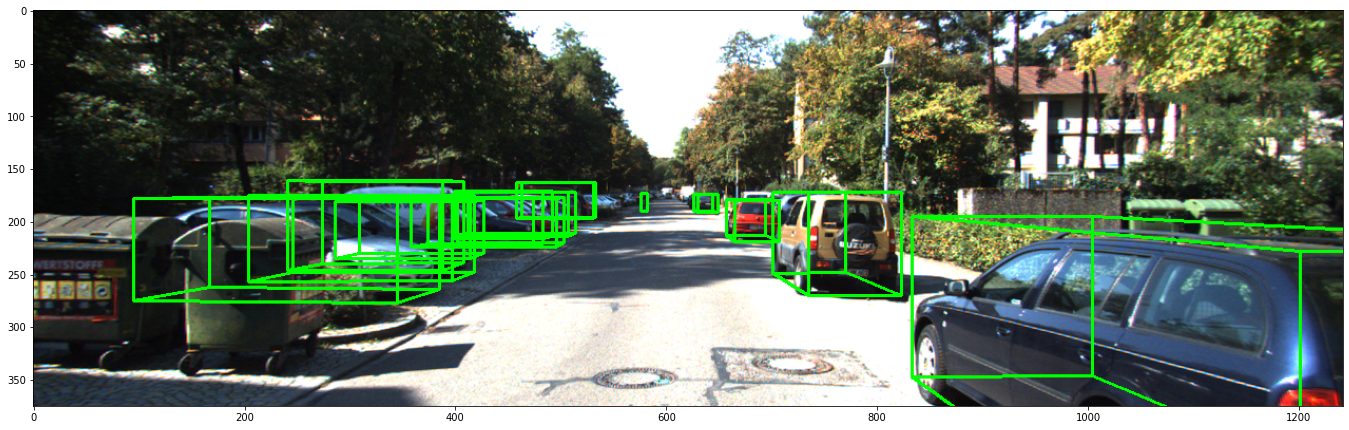

In [22]:
show_3d_detections(sample_name, 
                   gt_root_folder,
                   thresh=thresh,
                   show_lidar_img=show_lidar_img,
                   show_lidar_interactive=show_lidar_interactive, 
                   kitti_style=True,
                   lidar_dtype=np.float32)

## TEST LYFT TRAIN

In [23]:
sample_name = 'ffe26fcd931eb7fcb0ec6b3b0ab6e5aee1ac92e6359622ffaa0cceeda8063118'
show_lidar_img = True
show_lidar_interactive = False
thresh =0
gt_root_folder = '/dataset/kitti_format/lyft/train/'

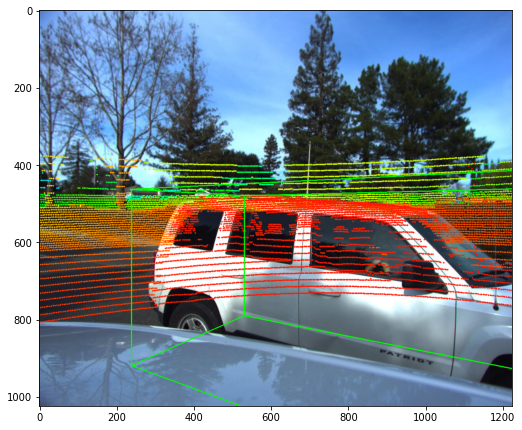

In [24]:
show_3d_detections(sample_name, 
                   gt_root_folder,
                   thresh=thresh,
                   show_lidar_img=show_lidar_img,
                   show_lidar_interactive=show_lidar_interactive, 
                   kitti_style=True,
                   lidar_dtype=np.float32)

## Frustum dataset test

In [3]:
sys.path.append('/root/workdir/frustum-convnet/')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

from datasets.provider_sample_waymo import ProviderDataset
import tensorflow.compat.v1 as tf
import tqdm
tf.enable_eager_execution()

In [4]:
def get_sample_names(dataset_path):
    dataset_idxs = []
    tfrecord_filenames = [f.path for f in os.scandir(dataset_path) if f.is_file() and f.name.endswith('.tfrecord')]
    datasets = []
    for dataset_idx, file_name in enumerate(tqdm.tqdm(tfrecord_filenames[:3])):
        dataset = tf.data.TFRecordDataset(file_name, compression_type='')
        datasets.append(dataset)
        for idx, _ in enumerate(dataset):
            dataset_idxs.append((dataset_idx, idx))
    return datasets, dataset_idxs

In [5]:
train_dataset_path = '/dataset/waymo/training/'
train_datasets, train_dataset_idxs = get_sample_names(train_dataset_path)

100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


In [6]:
train_dataset = ProviderDataset(
        1024,
        data_idxs_list=train_dataset_idxs,
        datasets = train_datasets,
        lidar_points_threshold=5,
        classes=['VEHICLE', 'PEDESTRIAN', 'CYCLIST'],
        one_hot=True,
        random_flip=True,
        random_shift=True,
        filter_objects=True)

In [7]:
images, calibs, pc, filtered_labels = train_dataset.__getitem__(43)

Element has been found!
Cam 1 Number of boxes before filtering 42
Cam 1 Number of boxes after filtering 8
Cam 3 Number of boxes before filtering 34
Cam 3 Number of boxes after filtering 21
Cam 0 Number of boxes before filtering 31
Cam 0 Number of boxes after filtering 13
Cam 2 Number of boxes before filtering 7
Cam 2 Number of boxes after filtering 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


KeyError: 4

In [ ]:
cam_idx = 3
img = images[cam_idx]
calib = calibs[cam_idx]
filtered_objects = filtered_labels[cam_idx]

img_to_draw = np.copy(img)

h, w, c = img.shape
# img_to_draw = show_lidar_on_image_my(pc[:,:3], img_to_draw, calib, w, h)
show_image_with_boxes_my(img_to_draw, filtered_objects, calib, show2d=True)

In [39]:
tf.__version__

'1.15.0'

In [41]:
import tensorflow

In [42]:
tensorflow.__version__

'1.15.0'